# Fake and Real Face Detection
### Goal
The goal of this project is to achieve a greater accuracy in detecting real and digitally created faces, which we will call *fake* for simplicity. We have surveyed a form (https://forms.gle/H5Spuu8ee3XXzP5Z6) to about one hundred people which required them to differentiate between 15 fake and real faces. In average, surveyed participants, distinguished 60% of the faces correctly.<br>

### Overview
We used tensorflow and keras for training our model. For image augmentation, instead, we used *imgaug* (https://github.com/aleju/imgaug) which comes with a variety of augmentations to choose from.<br>
For the image classification we used a **CNN** which took as input 128x128 images and 2 classes activated with softmax as output layer.<br><br>
We have trained our model in three different moments.<br> First, we trained on 10k images from the UTK dataset of aligned & cropped faces (https://susanqq.github.io/UTKFace/) for the *Real* label and the first 10k styleGAN images of the 1 million archive (https://archive.org/download/1mFakeFaces). <br>The second training was done on the 140k images, composed of 70k Flickr images collected by Nvidia for the *Real* classification and 70k styleGAN images for the *Fake*.<br>
The final training was done on 24k in-the-wild images from the UTK dataset for the *Real* classification, and 20k styleGAN images from the 1 million fake faces archive for the *Fake*.<br><br>
Our model was tested on 3.8k faces from the LAG  dataset (http://www.ivl.disco.unimib.it/activities/large-age-gap-face-verification/) and 5k from the CelebA dataset (http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html)for the *Real* classification; we used 10k styleGAN faces from the 1 million fake faces archive for the *Fake*. The datasets used for the testing were chosen for the variety of angles, lightning, filters, and alteration that the real faces contained. The different range of characteristics helped us carry out a more appropriate testing.<br><br>
The model showed 87% accuracy on the testing datasets.

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import albumentations
import tensorflow_addons as tfa
from tensorflow.keras import datasets, layers, models
import numpy as np
import matplotlib.pyplot as plt

## Training with Aligned & Cropped UTK and styleGAN from  1 million archive

We used *ImageDataGenerator* for loading our datasets. This library allowed us to simply handle our Xs and Ys data structures for the training, validation, and testing.<br>
Based on the paper, *CNN-generated images are surprisingly easy to spot... for now* from researchers at UC Berkeley, Adobe Research, and University of Minnesota, applying **blur** and **JPEG** compression helps a model detect real and fake faces with more generalization.<br>
We started by applying blur as image augmentation to our training data and rescaling the image colors to a a value between 0 and 1.<br>

In [2]:
TRAIN_DIR="./data/1m_utk/train"
VALID_DIR="./data/1m_utk/valid"
TEST_DIR="./data/1m_utk/test"

train_gen = ImageDataGenerator(
    rescale=(1./255),
    preprocessing_function=tfa.image.gaussian_filter2d
)
valid_gen = ImageDataGenerator(
    rescale=(1./255)
)
test_gen = ImageDataGenerator(
    rescale=(1./255)
)

train = train_gen.flow_from_directory(
    directory= TRAIN_DIR,
    target_size = (128, 128),
    batch_size=64,
    class_mode="binary"
       
)
valid = valid_gen.flow_from_directory(
    directory=VALID_DIR,
    target_size = (128, 128),
    batch_size=32,
    class_mode="binary"
    )
test = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size = (128, 128),
    class_mode="binary"    
)
from PIL import ImageFile
#Truncated images would give errors during training.
ImageFile.LOAD_TRUNCATED_IMAGES = True

Found 13846 images belonging to 2 classes.
Found 3956 images belonging to 2 classes.
Found 1978 images belonging to 2 classes.


### Model Description
This network layout is the successor of a more simplistic first model we tried.<br>
The differences in this model, compared to our previous model are:
- Instead of *Conv2D* and then a *MaxPooling*, this model has 2 *Conv2D* followed by a *MaxPooling*.
- *BatchNormalization* is applied to rescaled the values after the Conv2D.
- *Dropout* allows the model to avoid overfitting.

In [3]:
model = models.Sequential()
model.add(layers.Conv2D(64, kernel_size=(3,3), activation="relu", input_shape=(128,128,3)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(32, kernel_size=(3,3), activation="relu"))
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(64, kernel_size=(3,3), activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Dropout(0.25))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.25))
model.add(layers.Dense(2, activation="softmax"))

### Hyperparameters
The model starts with 1-e3 learning rate. A slow learning rate, which is further slowed down by *ReduceLROnPlateau*.<br>
The steps per epoch are training_samples//64 and validation_steps validation_samples//64.<br>
Loss function is *sparse categorical crossentropy* as the output layer is a *softmax* on with 2 classes.


In [4]:

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                              factor=0.1, 
                              verbose=2,
                              patience=10, min_lr=0.0001, mode="auto", )

In [5]:

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [6]:
history = model.fit(train, 
                    epochs=5, 
                    steps_per_epoch=10000//64, 
                    validation_steps=2000//64,
                    callbacks=[reduce_lr],
                    validation_data=valid,
                   )

Epoch 1/5
156/156 [==============================] - 134s 842ms/step - loss: 0.0342 - accuracy: 0.9885 - val_loss: 12.5111 - val_accuracy: 0.4899
Epoch 2/5
156/156 [==============================] - 132s 849ms/step - loss: 0.0046 - accuracy: 0.9985 - val_loss: 13.8471 - val_accuracy: 0.4950
Epoch 3/5
156/156 [==============================] - 132s 848ms/step - loss: 9.3667e-04 - accuracy: 0.9997 - val_loss: 1.3608 - val_accuracy: 0.7712
Epoch 4/5
156/156 [==============================] - 132s 849ms/step - loss: 6.5337e-04 - accuracy: 0.9997 - val_loss: 0.0768 - val_accuracy: 0.9768
Epoch 5/5
156/156 [==============================] - 133s 851ms/step - loss: 7.4494e-04 - accuracy: 0.9999 - val_loss: 0.0030 - val_accuracy: 0.9990


62/62 - 19s - loss: 0.0026 - accuracy: 0.9990


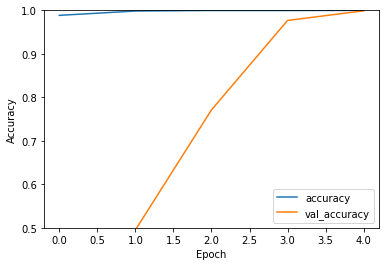

In [14]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test, verbose=2)

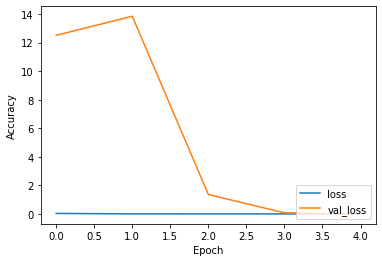

In [17]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
#plt.ylim([0.5, 1])
plt.legend(loc='lower right')


In [18]:
model.save("/tmp/model.h5")

## Training on Flickr images collected by Nvidia and styleGAN from the 1 million archive
A total of 140k images were used for this training.<br>
The images contained in this dataset we very useful for the training for two reasons:
- The model could train on more different images as the *Real* ones, as they were collected from Flickr, contained alterations, such as color filters, face filters, etc ...
- The *Real* images are the same that were used for training styleGAN.

### Added More Image Augmentation

The first training attempts on these images resulted in an overfit.<br>
The *accuracy* vs *validation_accuracy* graph clearly shows that the model was **overfitting**
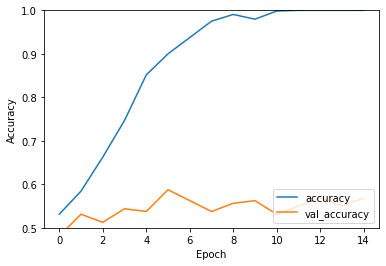

<br>
Adding more noise to the images helped avoiding th overfitting. Random <b>rotations</b>, <b>horizontal flips</b>, <b>brightness</b>, and <b>width/height shifts</b> allowed model to generalize more when training.

In [2]:
from imgaug import augmenters as iaa

aug1 = iaa.GaussianBlur(sigma=(0, 0.5))
#aug2 = iaa.JpegCompression(compression=(50, 65))

def add_augmentation(image):
    image = aug1.augment_image(image)
    #image = np.uint8(image * 255)
    #image = aug2.augment_image(image)
    #image = np.float64(image / 255.)
    return image


In [11]:
INPUT_DIR="/tmp/real_vs_fake/real-vs-fake"

#Added random variations to the images
train_gen = ImageDataGenerator(
    rescale=(1./255),
    rotation_range=20,
    horizontal_flip=True,
    vertical_flip=False,
    brightness_range=(0.5, 1.3),
    width_shift_range=0.18,
    height_shift_range=0.18,
    preprocessing_function=add_augmentation
                              )
valid_gen = ImageDataGenerator(
    rescale=(1./255)
)
test_gen = ImageDataGenerator(
    rescale=(1./255)
)

train = train_gen.flow_from_directory(
    directory= INPUT_DIR+"/train",
    target_size = (128, 128),
    batch_size=64,
    class_mode="binary"
       
)
valid = valid_gen.flow_from_directory(
    directory=INPUT_DIR+"/valid",
    target_size = (128, 128),
    batch_size=32,
    class_mode="binary"
    )
test = test_gen.flow_from_directory(
    directory=INPUT_DIR+"/test",
    target_size = (128, 128),
    class_mode="binary"    
)
from PIL import ImageFile
#Truncated images would give errors during training.
ImageFile.LOAD_TRUNCATED_IMAGES = True

Found 126562 images belonging to 2 classes.
Found 28576 images belonging to 2 classes.
Found 24279 images belonging to 2 classes.


In [7]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0" #Making sure the gpu used was only the GPU_0
model = tf.keras.models.load_model('/tmp/model.h5')

In [9]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                              factor=0.1, 
                              verbose=2,
                              patience=10, min_lr=0.0001, mode="auto", )

In [5]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [10]:
history = model.fit(train, 
                    epochs=5, 
                    steps_per_epoch=100000//64, 
                    validation_steps=20000//64,
                    callbacks=[reduce_lr],
                    validation_data=valid,
                    #shuffle=True
                   )

Epoch 1/5
1562/1562 [==============================] - 728s 465ms/step - loss: 0.4708 - accuracy: 0.7737 - val_loss: 0.5120 - val_accuracy: 0.7525
Epoch 2/5
1562/1562 [==============================] - 695s 445ms/step - loss: 0.2536 - accuracy: 0.8939 - val_loss: 0.4453 - val_accuracy: 0.8285
Epoch 3/5
1562/1562 [==============================] - 701s 449ms/step - loss: 0.1611 - accuracy: 0.9369 - val_loss: 0.1344 - val_accuracy: 0.9486
Epoch 4/5
1562/1562 [==============================] - 683s 437ms/step - loss: 0.1119 - accuracy: 0.9576 - val_loss: 0.1335 - val_accuracy: 0.9463
Epoch 5/5
1562/1562 [==============================] - 683s 437ms/step - loss: 0.0878 - accuracy: 0.9667 - val_loss: 0.0973 - val_accuracy: 0.9632


625/625 - 62s - loss: 0.0938 - accuracy: 0.9651


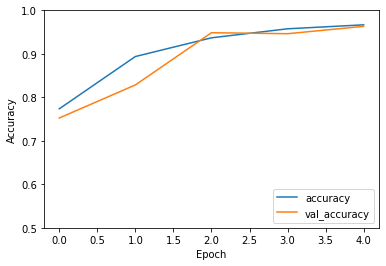

In [11]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test, verbose=2)

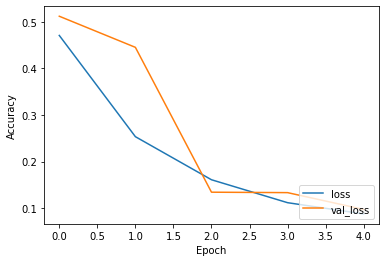

In [12]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
#plt.ylim([0.5, 1])
plt.legend(loc='lower right')


In [7]:
model.save("/tmp/model-aug0.h5")

## Training on in-the-wild UTK faces and styleGAN from 1million archive
The *Real* faces used for this training were different from the first training.<br> The faces were not aligned and cropped, but rather in-the-wild. The photos were taken from different angles, with different backgrounds, in different lightning. More similar to how a normal photo would be taken. This dataset allowed the training to better detect faces that were not only presented as a document photo.

In [12]:
INPUT_DIR="/tmp/inputs/1m_utk_123"

train_gen = ImageDataGenerator(
    rescale=(1./255),
    rotation_range=20,
    horizontal_flip=True,
    vertical_flip=False,
    brightness_range=(0.5, 1.3),
    width_shift_range=0.18,
    height_shift_range=0.18,
    preprocessing_function=add_augmentation
                              )
valid_gen = ImageDataGenerator(
    rescale=(1./255)
)
test_gen = ImageDataGenerator(
    rescale=(1./255)
)

train = train_gen.flow_from_directory(
    directory= INPUT_DIR+"/train",
    target_size = (128, 128),
    batch_size=64,
    class_mode="binary"
       
)
valid = valid_gen.flow_from_directory(
    directory=INPUT_DIR+"/valid",
    target_size = (128, 128),
    batch_size=32,
    class_mode="binary"
    )
test = test_gen.flow_from_directory(
    directory=INPUT_DIR+"/test",
    target_size = (128, 128),
    class_mode="binary"    
)
from PIL import ImageFile
#Truncated images would give errors during training.
ImageFile.LOAD_TRUNCATED_IMAGES = True

Found 30875 images belonging to 2 classes.
Found 8820 images belonging to 2 classes.
Found 4412 images belonging to 2 classes.


In [4]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0" #Making sure the gpu used was only the GPU_0
model = tf.keras.models.load_model('/tmp/model-aug0.h5')

In [5]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                              factor=0.1, 
                              verbose=2,
                              patience=10, min_lr=0.0001, mode="auto", )

In [6]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [7]:
history = model.fit(train, 
                    
                    epochs=5, 
                    steps_per_epoch=30875//64, 
                    validation_steps=8820//64,
                    callbacks=[reduce_lr],
                    validation_data=valid,
                    #shuffle=True
                   )

Epoch 1/5
482/482 [==============================] - 454s 938ms/step - loss: 0.1363 - accuracy: 0.9522 - val_loss: 0.0984 - val_accuracy: 0.9651
Epoch 2/5
482/482 [==============================] - 453s 941ms/step - loss: 0.1127 - accuracy: 0.9595 - val_loss: 0.0734 - val_accuracy: 0.9745
Epoch 3/5
482/482 [==============================] - 450s 934ms/step - loss: 0.1028 - accuracy: 0.9636 - val_loss: 0.1199 - val_accuracy: 0.9587
Epoch 4/5
482/482 [==============================] - 451s 936ms/step - loss: 0.0939 - accuracy: 0.9662 - val_loss: 0.0905 - val_accuracy: 0.9683
Epoch 5/5
482/482 [==============================] - 451s 935ms/step - loss: 0.0862 - accuracy: 0.9695 - val_loss: 0.0509 - val_accuracy: 0.9849


138/138 - 41s - loss: 0.0509 - accuracy: 0.9812


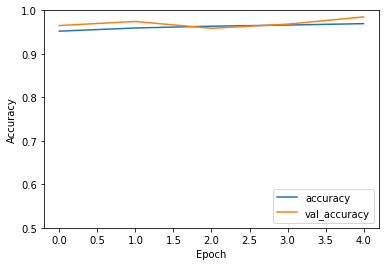

In [13]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test, verbose=2)

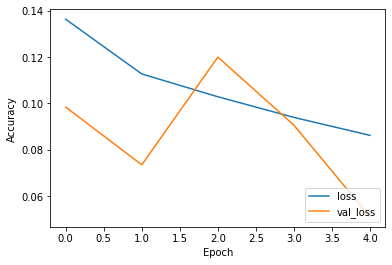

In [14]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
#plt.ylim([0.5, 1])
plt.legend(loc='lower right')


In [10]:
model.save("/tmp/model-aug1.h5")

In [8]:
test = test_gen.flow_from_directory(
    directory="/tmp/inputs/testing/",
    target_size = (128, 128),
    class_mode="binary"    
)

Found 13818 images belonging to 2 classes.


## Testing on a more appropriate dataset
The testing being done on the same immages provided a result that could only verify the accuracy for images similar to the ones used for the training. <br>The images used for the final testing are taken from the LAG (http://www.ivl.disco.unimib.it/activities/large-age-gap-face-verification/) and CelebA (http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) datasets for *Real* faces and from the 1 million fake faces archive for the digitally created ones. <br>The images used for this testing, provided a wider variety of photos taken in different backgrounds, angles, environments. The images also included subjects from a large age gap.<br>
The model performance on this test dataset resulted with an accuracy of 87%

In [9]:
model.evaluate(test)

432/432 [==============================] - 132s 304ms/step - loss: 0.3754 - accuracy: 0.8770


[0.3753596544265747, 0.8770444393157959]